# Wildlife Conservation in Côte d'Ivoire

Across the globe, a wide variety of creatures share the planet with humans — including countless species of wildlife. Unfortunately, many of these animals are increasingly threatened by human activities such as hunting and climate change. This growing pressure has made the need for efficient and scalable wildlife monitoring tools more urgent than ever.


Traditional methods — like manually reviewing footage from camera traps — are both time-consuming and labor-intensive. Moreover, these traps often generate large volumes of data, much of which is of medium or low quality, making it difficult for humans to process and analyze effectively.


However, with rapid advancements in Artificial Intelligence — particularly in Deep Learning and Computer Vision — we can now build models capable of automatically analyzing camera trap images. These technologies offer powerful tools to monitor biodiversity, study animal behavior, and support conservation planning efforts aimed at protecting wildlife from emerging threats.

## I. Project Description

Manually analyzing thousands of wildlife images is a time-consuming and error-prone process, especially when the image quality is low due to lighting conditions or animal movement. There is a strong need for an automated solution that can accurately classify these images and support ecological research at scale.

The goal of this project is to build a model capable of identifying the species of animals captured by camera traps used in conservation efforts. The dataset includes over 16,000 images categorized into 8 different species.


This type of project can be particularly beneficial for ecologists, wildlife researchers, and organizations involved in biodiversity monitoring. It can also be valuable to companies working on computer vision applications in environmental contexts.

This project is part of a competition launched by the DrivenData platform. 

**This project uses data from:**
> The Pan African Programme: The Cultured Chimpanzee, Wild Chimpanzee Foundation, DrivenData. (2022). Conser-vision Practice Area: Image Classification. Retrieved from https://www.drivendata.org/competitions/87/competition-image-classification-wildlife-conservation/.


## II. Reading and Exploring Files

#### a. Getting Started 

Let's start by importing the packages needed in this notebook :

In [1]:
import os  
import sys 
import copy
import shutil
from collections import Counter  
import matplotlib 
import matplotlib.pyplot as plt  
import numpy as np 
import pandas as pd 
import PIL  
import torch 
import torch.nn as nn  
import torch.optim as optim 
import torchvision  
from torch.utils.data import DataLoader, random_split  
from torchinfo import summary
from torchvision import datasets, transforms  
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix  
from tqdm.notebook import tqdm  
torch.backends.cudnn.deterministic = True  

Print out the versions of our packages. If we come back to this later, we'll know what we used.

In [2]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("Python libraries :")
print("-----"*13)
print("  matplotlib version:  ", matplotlib.__version__)
print("  pandas version:      ", pd.__version__)
print("  PIL version:         ", PIL.__version__)
print("  torch version:       ", torch.__version__)
print("  torchvision version: ", torchvision.__version__)

Platform: linux
Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Python libraries :
-----------------------------------------------------------------
  matplotlib version:   3.7.2
  pandas version:       2.2.3
  PIL version:          11.2.1
  torch version:        2.6.0+cu124
  torchvision version:  0.21.0+cu124


Since we’ll be running on `GPUs`, the device should be set to `CUDA`.

In [3]:
if torch.cuda.is_available():
    device="cuda"
else:
    device="cpu"

print(f"Using {device} device.")

Using cuda device.


#### b. Loading Dataset 

In this project, the dataset consists of images from **camera traps** in [Taï National Park](https://en.wikipedia.org/wiki/Ta%C3%AF_National_Park).
The dataset is composed of two folders, `train_feature` and `test_features`, which contains the training and testing images in **JPG** format.

In [4]:
# Train and test folder path :
train_features_folder = "/kaggle/input/wildlife-conservation-in-cte-divoire/Wildlife_Conservation/train_features"   
test_features = "/kaggle/input/wildlife-conservation-in-cte-divoire/Wildlife_Conservation/test_features"
# cheking :
print(f"The train_features set contains {len(os.listdir(train_features_folder))} images, with the first file being {os.listdir(train_features_folder)[0]}")
print(f"The test_features set contains {len(os.listdir(test_features))} images, with the first file being {os.listdir(test_features)[0]}")

The train_features set contains 16488 images, with the first file being ZJ003277.jpg
The test_features set contains 4464 images, with the first file being ZJ020900.jpg


Each image is accompanied by additional metadata stored in `train_features.csv` and `test_features.csv`. These files include the following fields:
+ `id` (string, unique identifier): A unique identifier for each image.
+ `filepath` (string, feature): The path to the image, including its directory (train or test).
+ `site` (string, feature): The location where the image was captured.

In [5]:
# Train and test files path:
train_features_path = "/kaggle/input/wildlife-conservation-in-cte-divoire/Wildlife_Conservation/train_features.csv"
test_features_path = "/kaggle/input/wildlife-conservation-in-cte-divoire/Wildlife_Conservation/test_features.csv"
#Load the CSV files
train_features = pd.read_csv(train_features_path , index_col="id") 
test_features_file = pd.read_csv(test_features_path , index_col="id")
#Cheking
print(" Train features :")
print(train_features.head())
print("___"*15)
print(" Test features :")
print(test_features_file.head())

 Train features :
                             filepath   site
id                                          
ZJ000000  train_features/ZJ000000.jpg  S0120
ZJ000001  train_features/ZJ000001.jpg  S0069
ZJ000002  train_features/ZJ000002.jpg  S0009
ZJ000003  train_features/ZJ000003.jpg  S0008
ZJ000004  train_features/ZJ000004.jpg  S0036
_____________________________________________
 Test features :
                            filepath   site
id                                         
ZJ016488  test_features/ZJ016488.jpg  S0082
ZJ016489  test_features/ZJ016489.jpg  S0040
ZJ016490  test_features/ZJ016490.jpg  S0040
ZJ016491  test_features/ZJ016491.jpg  S0041
ZJ016492  test_features/ZJ016492.jpg  S0040


Finally, the `labels.csv` file contains the labels of the images. Each image belongs to one of the following classes: 
1.   **blank**
2.   **antelope_duiker**
3.   **bird**
4.   **civet_genet**
5.   **hog**
6.   **leopard**
7.   **monkey_prosimian**
8.   **rodent**


In [6]:
#
train_labels_path = "/kaggle/input/wildlife-conservation-in-cte-divoire/Wildlife_Conservation/train_labels.csv"
#Load csv file :
train_labels = pd.read_csv(train_labels_path )
#Cheking 
print("Train labels columns :", list(train_labels.columns ))

Train labels columns : ['id', 'antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']


>  📌 More information : [Problem description](https://www.drivendata.org/competitions/87/competition-image-classification-wildlife-conservation/page/483/)

#### c. Create Classes 

 The objective of this project is to develop a model capable of identifying wildlife in images collected from camera traps.</br>
 Although the dataset includes eight distinct classes, the images in the train folder are not sorted by class. To associate each image with its corresponding class, we rely on the information provided in the CSV files.

> 🛠️ **Step 1**: Create output subfolder for each classes

In [7]:
train_folder = "/kaggle/working/train_data"
classes = train_labels.columns[1:] 
for label in classes :
    class_folder = os.path.join(train_folder,label)
    os.makedirs(class_folder, exist_ok=True)

#cheking
os.listdir(train_folder)

['monkey_prosimian',
 'leopard',
 'bird',
 'civet_genet',
 'antelope_duiker',
 'blank',
 'hog',
 'rodent']

> 🛠️ **Step 2**: Copy images and organize them by class

In [8]:
for _, row in train_labels.iterrows():
    image_id = row["id"]
    # Find the associated file path
    image_path = train_features[train_features.index == image_id]['filepath'].str.split('/', expand=True)[1].values[0]
    full_image_path = os.path.join(train_features_folder, image_path)

    # Get the class labels for this image
    for label in classes:
        if row[label] == 1.0:  # If the class label is 1.0, it belongs to this class
            destination_folder = os.path.join(train_folder, label)
            shutil.copy(full_image_path, destination_folder) 
            break  # Assuming the image belongs to one class only

print("Images successfully divided into class folders!")

Images successfully divided into class folders!


#### d. Explore Dataset  

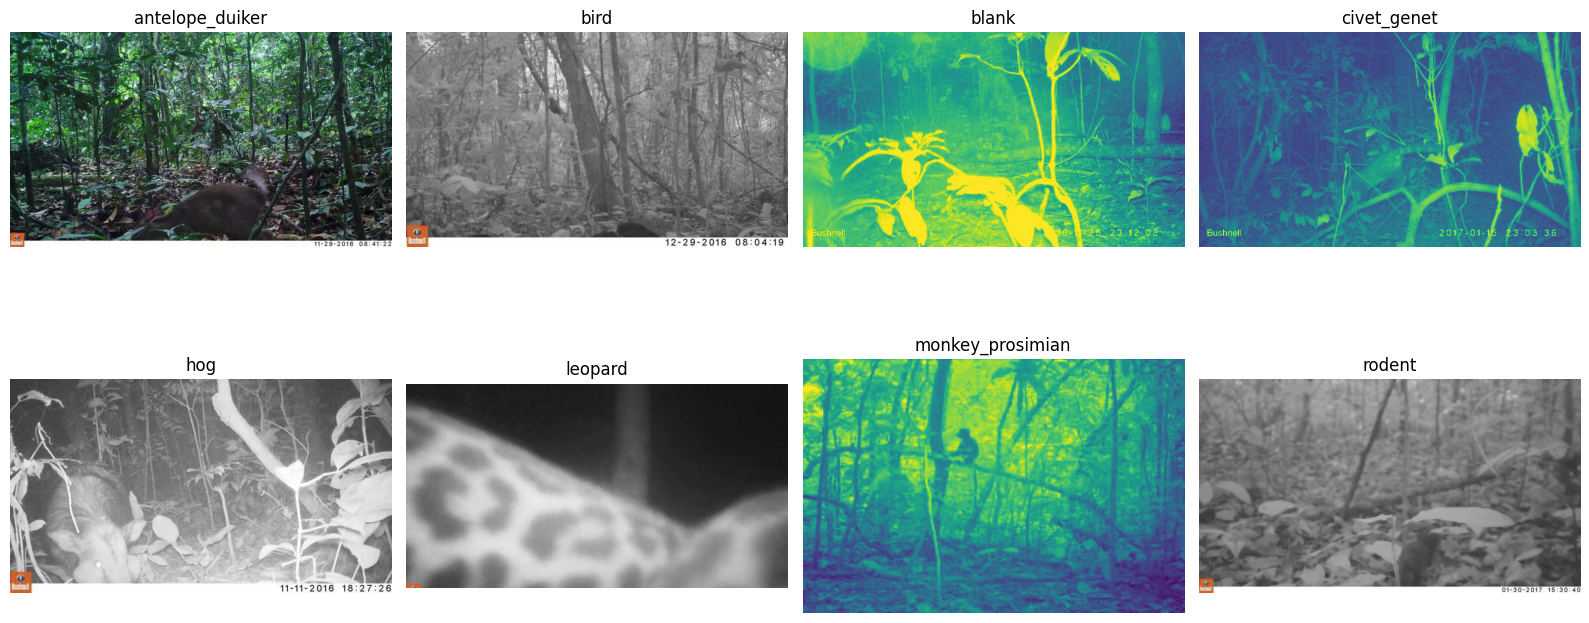

In [9]:
from PIL import Image
# Plot setup
plt.figure(figsize=(16, 8))

for i, folder in enumerate(classes[:8]): 
    folder_path = os.path.join(train_folder, folder)
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg'))]

    if not image_files:
        continue  # Skip if folder has no images

    # Load an image from the folder
    image_path = os.path.join(folder_path, image_files[10])
    image = Image.open(image_path)

    # Display
    plt.subplot(2, 4, i+1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(folder)

plt.tight_layout()
plt.show()

In the previous images, it is difficult to quickly determine whether they actually contain an animal or what type it is. This becomes a significant issue when processing hundreds or thousands of images.</br>
Here, we begin to see the advantage of having a computer identify whether an animal is present and determine its species.

## III. Preparing Our Data

After loading and exploring the data, the next step is to ensure that all images are in the same format and properly prepared. Since we'll be working with images, we need to confirm that they are in RGB mode; if not, we must convert them accordingly. In addition, all images should have the same dimensions. We also need to convert them into a format that the neural network can process.</br> 
Neural networks typically perform best when the input data has a mean of 0 and a standard deviation of 1, so the final step in preprocessing will be to normalize the data.

> 🛠️ **Step 1**: Create `Conv_To_RGB` class

In [10]:
class Conv_To_RGB:
    def __call__(self, image):
        if image.mode!="RGB":
            return image.convert('RGB')
        return image
        

> 🛠️ **Step 2**: Calculate the `mean` and `std`

+  The formula for the `mean` is: : $$\mu=\frac{1}{N}\sum_{b=1}^{N}{x_i}$$
 where:
   - $x_{i}$:  the value of the ithith observation
   - $N$ : the total number of observations </br>
When processing data in batches of equal size, we can approximate the dataset mean using the mean of each batch:
$$\mu \approx \frac{1}{B}\sum_{b=1}^{B}{mean\ of\ batches_b}$$
where $B$ is the number of batches.
+ The formula for the `standard deviation` is: $$ \sigma= \sqrt{\mathbb{E(x^2)} - \mathbb{E(x)}^2}$$
   For large datasets, the Law of Large Numbers tells us that:
  $$Sample\ mean \approx  \mathbb{E(x)}$$

    

In [11]:
# Create a function to calculate the mean and standard deviation
def get_mean_std(loader):
    """Compute the mean and std of images data
    input: a DataLoader
    output: mean and std of each channel (as tensors)
    """
    channel_sum = 0.0
    channel_squared_sum = 0.0
    num_batches = 0

    for data, _ in loader:
        mean_per_batch = torch.mean(data, dim=[0, 2, 3])
        squared_mean_per_batch = torch.mean(data ** 2, dim=[0, 2, 3])
        channel_sum += mean_per_batch
        channel_squared_sum += squared_mean_per_batch
        num_batches += 1
    mean = channel_sum / num_batches
    std = (channel_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

#calculate the mean and std: 
transform = transforms.Compose(
    [   Conv_To_RGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),]
)

dataset = datasets.ImageFolder(root=train_folder,transform=transform)
loader = DataLoader(dataset, batch_size=64)
mean ,std = get_mean_std(loader)
print(f'Mean equal :{mean}.')
print(f'std equal :{std}')

Mean equal :tensor([0.4789, 0.4926, 0.4834]).
std equal :tensor([0.2542, 0.2471, 0.2501])


> 🛠️ **Step 3**: Create Normalization pipeline

The required transformations are:

   + Convert any grayscale images to RGB mode.
 
   + Resize the images to 224×224 pixels.

   + Convert the images to tensors.

   + Normalize the data using the computed mean and standard deviation values.

In [12]:
#Normalization pipeline :
transform = transforms.Compose(
    [
        Conv_To_RGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
       
    ]
)


>🛠️ Step 4: Create Normalizated dataset

In [13]:
#create normalized dataset 
norm_dataset = datasets.ImageFolder(root=train_folder,transform=transform)
#checking 
batch_size=64
loader = DataLoader(norm_dataset, batch_size=batch_size)
mean ,std = get_mean_std(loader)
print(f'Mean equal :{mean}.')
print(f'std equal :{std}')

Mean equal :tensor([ 7.3720e-07, -1.4520e-07,  1.0393e-06]).
std equal :tensor([1.0000, 1.0000, 1.0000])


✅ Great, our data is properly normalized. Now, let's move on to splitting it.

## IV. Train and Validation Splitting 

One of the most important techniques to monitor a model’s learning progress and prevent overfitting is to split the dataset into training and validation sets.</br> 
The training set is used to teach the model, while the validation set helps evaluate its performance on unseen data during training.

>Create a trainings dataset with 80% of the data, and a validation set with 20%

In [14]:
#split the dataset:
g = torch.Generator()
g.manual_seed(42)
train_dataset, val_dataset = random_split(norm_dataset,[.8,.2])
#Checking
percent_train = np.round(100*(len(train_dataset)/len(norm_dataset)),2)
percent_val=np.round(100*(len(val_dataset)/len(norm_dataset)),2)
print(f"The training set represents {percent_train}% of the total data.")
print(f"The Validation set represents {percent_val}% of the total data.")


The training set represents 80.0% of the total data.
The Validation set represents 20.0% of the total data.


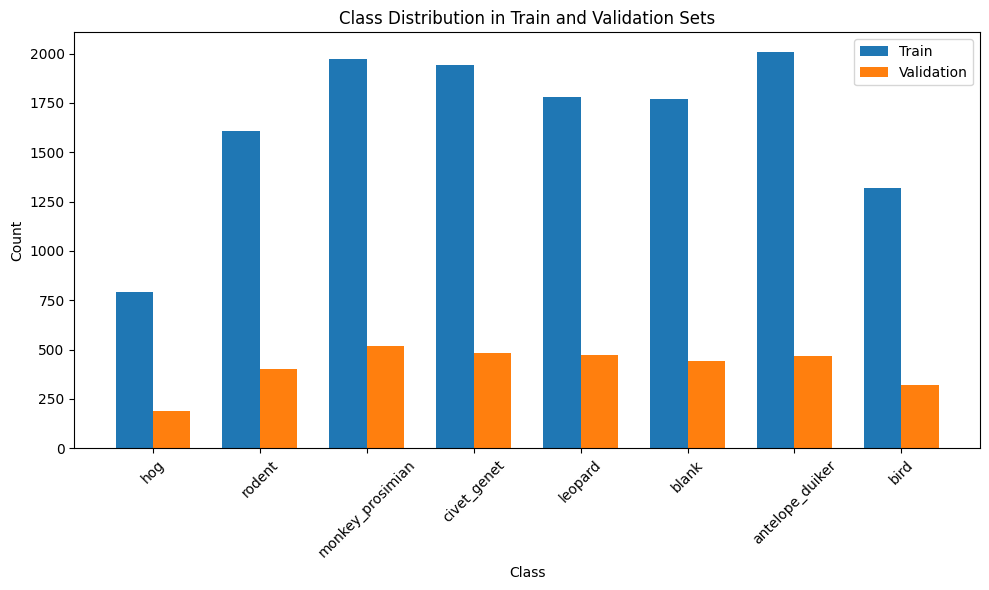

In [15]:
#Class Distribution Graph :
#create count function :
def class_counts_df(dataset,desc):
    # Count the class indices
    c = Counter(label for _, label in dataset)
    # Map indices to class names
    idx_to_class = {v: k for k, v in dataset.dataset.class_to_idx.items()}
    # Build list of dictionaries
    data = [{'class_name': idx_to_class[idx], desc: count} for idx, count in c.items()]
    # Create DataFrame
    df = pd.DataFrame(data).set_index('class_name')
    return df

#Concatenate the train and validation dataframe:
dataset_count = pd.concat([class_counts_df(train_dataset,"train"),class_counts_df(val_dataset,"validation")],axis=1)

#Display the results :
labels = dataset_count.index
x = np.arange(len(labels))  # label locations
width = 0.35  # width of the bars
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, dataset_count['train'], width, label='Train')
plt.bar(x + width/2, dataset_count['validation'], width, label='Validation')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in Train and Validation Sets')
plt.xticks(x, labels, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

✅ From the graph, we can clearly see that the validation set represents approximately one-quarter of the training set across all classes.

## V.  Model Building 

> 🛠️ **Step 1** : Create Image Classifier class 

In this notebook, I present a custom-built ImageClassifier class that streamlines the workflow for image classification using deep learning. The class is modular and easy to use, covering all key steps — from model initialization and data transformation to training, validation, evaluation, and prediction. It also includes useful tools such as confusion matrix generation and metric visualization to help monitor model performance throughout the training process.

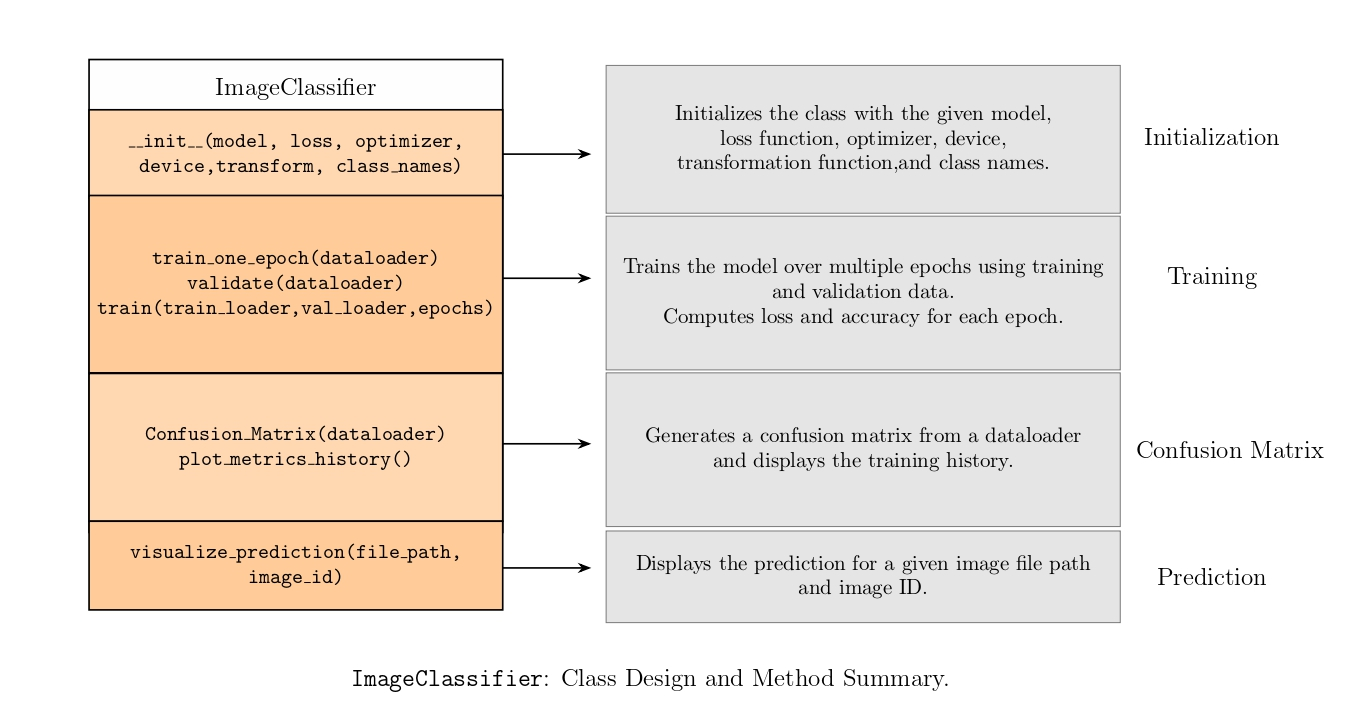

**Evaluation Metrics:**
We use the following formulas to compute performance during training and validation:
+ `Average Loss :`
$$Loss = \frac{1}{N}\sum_{i=1}^{N}{L_{i}}$$
where $L_{i}$ is the loss for $i^{th}$ sample (e.g, cross-entropy).
+ `Accuracy :`
  $$Accuracy = \frac{1}{N}\sum_{i=1}^{N}{1[\hat{y_{i}}=y_{i}]}$$
Where $1[.]$ is 1 if the prediction $\hat{y_{i}}$ matches the true label $y_{i}$, and 0 otherwise.

In [16]:
class ImageClassifier:
    def __init__(self, model, criterion, optimizer, device,transform, class_names):
        self.model = model.to(device)
        self.criterion = criterion #
        self.optimizer = optimizer #
        self.device = device  #
        self.transform = transform   #
        self.class_names = class_names #

    def train_one_epoch(self, dataloader):
        total_loss, correct, total = 0.0, 0, 0
        self.model.train()  # Set model to training mode
        for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
            self.optimizer.zero_grad()
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)

            # Forward pass
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            # Backpropagation and optimizer step
            loss.backward()
            self.optimizer.step()
            # Accumulate loss
            total_loss += loss.item() * inputs.size(0)

           # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = total_loss / len(dataloader.dataset)
        accuracy = correct / total
        return epoch_loss, accuracy

    def validate(self, dataloader):
        self.model.eval()  
        total_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():  # No gradients needed for validation
            for inputs, targets in tqdm(dataloader, desc="Validating", leave=False):
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)
                outputs = self.model(inputs)

                # Calculate loss value
                loss = self.criterion(outputs, targets)
                total_loss += loss.item() * inputs.size(0)

                # Calculate accuracy 
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == targets).sum().item()
                total += targets.size(0)

        average_loss = total_loss / total
        accuracy = correct / total
        return average_loss, accuracy

    def train(self, train_loader, val_loader, epochs):
         # Initialization 
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []
        best_save_accuracy = 0.00
        lowest_val_loss = float('inf')
        self.best_model_state = None
        #create model folder 
        os.makedirs('/kaggle/working/model', exist_ok=True)
        for epoch in range(epochs):
            train_loss, train_accuracy = self.train_one_epoch(train_loader)
            val_loss, val_accuracy = self.validate(val_loader)
            print(f"Epoch {epoch+1} :")
            print(f"Training loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
            print(f"Validation loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
            # Save metrics 
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_accuracy)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_accuracy)
            #save the best model 
            if val_accuracy > best_save_accuracy and val_loss < lowest_val_loss:
               best_save_accuracy = val_accuracy
               lowest_val_loss = val_loss
               self.best_model_state = copy.deepcopy(self.model.state_dict())
               print(f"✅ Saved model at epoch {epoch+1} (acc↑, loss↓)")
        # Save the best model to file
        if self.best_model_state is not None:
           torch.save(self.best_model_state, '/kaggle/working/model/best_model.pth')

    
    def Confusion_Matrix(self, dataloader):
        # Load best model weights
        self.model.load_state_dict(self.best_model_state)
        self.model.eval()

        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in tqdm(dataloader, desc="Predicting", leave=False):
                inputs = inputs.to(self.device)  # Assuming self.device is defined
                labels = labels.to(self.device)

                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)

                all_preds.extend(preds.cpu().tolist())
                all_labels.extend(labels.cpu().tolist())

        # Compute confusion matrix
        cm = confusion_matrix(all_labels, all_preds)
        class_names = ['hog', 'rodent', 'civet genet', 'leopard',
                       'monkey prosimian', 'antelope duiker', 'bird', 'blank']

        # Display confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(xticks_rotation=90, cmap="Blues")


    def plot_metrics_history(self):
        epochs = range(1, len(self.train_losses) + 1)
        best_epoch = self.val_accuracies.index(max(self.val_accuracies)) + 1
        best_val_acc = max(self.val_accuracies)

        plt.figure(figsize=(12, 5))

        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, label='Train Loss')
        plt.plot(epochs, self.val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss over Epochs')
        plt.legend()

        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_accuracies, label='Train Accuracy')
        plt.plot(epochs, self.val_accuracies, label='Val Accuracy')
        plt.scatter(best_epoch, best_val_acc, color='red', s=100, edgecolor='black', label=f'Best Val Acc ({best_val_acc:.2f})', zorder=5)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy over Epochs')
        plt.legend()
 
        plt.tight_layout()
        plt.show()

    def visualize_prediction(self, file_path, image_id):
        # Load and preprocess image
        image = Image.open(file_path).convert("RGB")
        transformed = self.transform(image).unsqueeze(0).to(self.device)

        # Inference
        self.model.load_state_dict(self.best_model_state)
        self.model.eval()
        with torch.no_grad():
            output = self.model(transformed)
            confidence = torch.nn.functional.softmax(output, dim=1).squeeze().cpu().numpy()

        # Create confidence DataFrame
        conf_df = pd.DataFrame([confidence], columns=self.class_names, index=[image_id])

        # Create side-by-side plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        # Bar chart (horizontal)
        conf_df.T.plot(kind="barh", legend=False, ax=ax1, color="skyblue")
        ax1.set_title("Confidence Scores")
        ax1.set_xlim(0, 1)
        ax1.grid(True, linestyle="--", alpha=0.6)

        # Image display
        ax2.imshow(image)
        ax2.axis("off")
        ax2.set_title(f"Image: {image_id}")

        plt.tight_layout()
        plt.show()
   

> 🛠️ **Step 2** Model architecture 

The model used in this project is a convolutional neural network (CNN) designed for image classification tasks. It consists of multiple convolutional and pooling layers to extract spatial features, followed by fully connected layers for classification. This architecture enables the model to learn hierarchical patterns in the input images and make accurate predictions based on learned features.

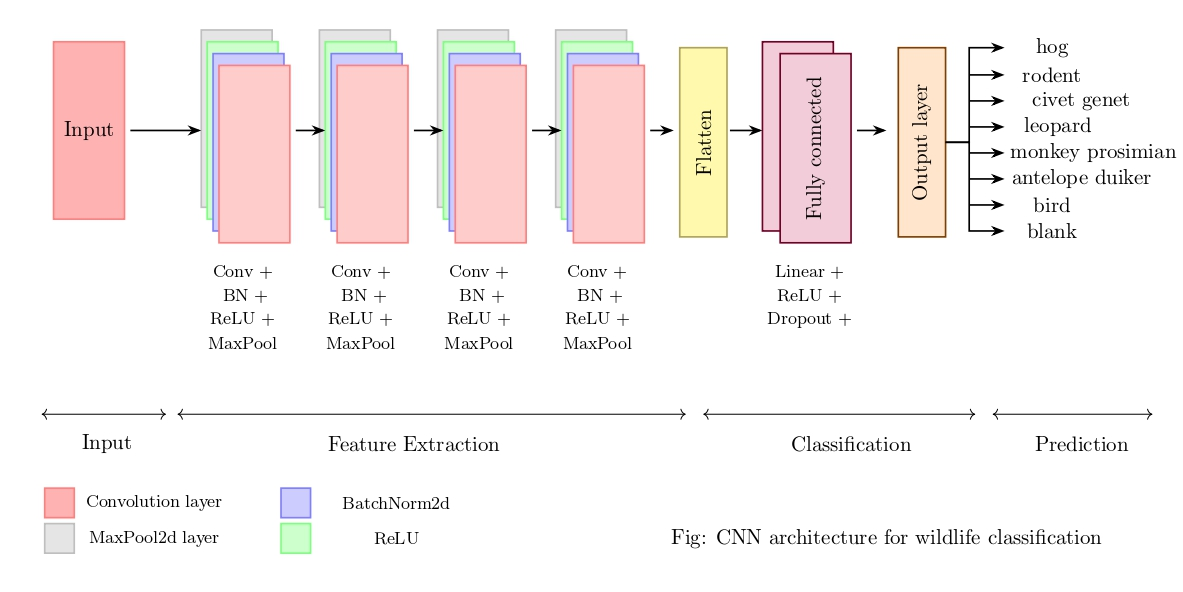

In [17]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = torch.nn.Sequential(
                
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=2),

    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=2),

    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Flatten(),
    nn.Dropout(),

    nn.Linear(in_features= 25088, out_features= 1024),
    nn.ReLU(),
    nn.Dropout(),

    nn.Linear(in_features= 1024, out_features= 256),
    nn.ReLU(),
    nn.Dropout(),

    nn.Linear(in_features= 256, out_features= 8),
)

# summary 
batch_size=64
height, width = 224, 224
summary(model, input_size=(batch_size, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [64, 8]                   --
├─Conv2d: 1-1                            [64, 16, 224, 224]        448
├─BatchNorm2d: 1-2                       [64, 16, 224, 224]        32
├─ReLU: 1-3                              [64, 16, 224, 224]        --
├─MaxPool2d: 1-4                         [64, 16, 112, 112]        --
├─Conv2d: 1-5                            [64, 32, 112, 112]        4,640
├─BatchNorm2d: 1-6                       [64, 32, 112, 112]        64
├─ReLU: 1-7                              [64, 32, 112, 112]        --
├─MaxPool2d: 1-8                         [64, 32, 56, 56]          --
├─Conv2d: 1-9                            [64, 64, 56, 56]          18,496
├─BatchNorm2d: 1-10                      [64, 64, 56, 56]          128
├─ReLU: 1-11                             [64, 64, 56, 56]          --
├─MaxPool2d: 1-12                        [64, 64, 28, 28]          --
├─Conv

> 🛠️ **Step 3** Train our model 

In [18]:
#create train and validation data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=g)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, generator=g)
#define loss fonction 
loss_fn = nn.CrossEntropyLoss()
#define opitimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to(device)
IC = ImageClassifier(model, loss_fn, optimizer, device, transform=transform, class_names=dataset.classes)

In [19]:
#training our model with 40 epochs:
IC.train(train_loader, val_loader, 40)

Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 1 :
Training loss: 1.8968, Accuracy: 0.3069
Validation loss: 1.5330, Accuracy: 0.3776
✅ Saved model at epoch 1 (acc↑, loss↓)


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 2 :
Training loss: 1.5862, Accuracy: 0.3744
Validation loss: 1.4258, Accuracy: 0.4316
✅ Saved model at epoch 2 (acc↑, loss↓)


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 3 :
Training loss: 1.4716, Accuracy: 0.4272
Validation loss: 1.3152, Accuracy: 0.5099
✅ Saved model at epoch 3 (acc↑, loss↓)


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 4 :
Training loss: 1.3804, Accuracy: 0.4710
Validation loss: 1.2501, Accuracy: 0.5153
✅ Saved model at epoch 4 (acc↑, loss↓)


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 5 :
Training loss: 1.2942, Accuracy: 0.5137
Validation loss: 1.1241, Accuracy: 0.5587
✅ Saved model at epoch 5 (acc↑, loss↓)


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 6 :
Training loss: 1.2080, Accuracy: 0.5397
Validation loss: 1.0525, Accuracy: 0.6012
✅ Saved model at epoch 6 (acc↑, loss↓)


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 7 :
Training loss: 1.1324, Accuracy: 0.5783
Validation loss: 0.9789, Accuracy: 0.6576
✅ Saved model at epoch 7 (acc↑, loss↓)


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 8 :
Training loss: 1.0440, Accuracy: 0.6115
Validation loss: 0.9088, Accuracy: 0.6733
✅ Saved model at epoch 8 (acc↑, loss↓)


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 9 :
Training loss: 0.9778, Accuracy: 0.6423
Validation loss: 0.8219, Accuracy: 0.7137
✅ Saved model at epoch 9 (acc↑, loss↓)


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 10 :
Training loss: 0.9114, Accuracy: 0.6666
Validation loss: 0.7792, Accuracy: 0.7146
✅ Saved model at epoch 10 (acc↑, loss↓)


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 11 :
Training loss: 0.8442, Accuracy: 0.6883
Validation loss: 0.7524, Accuracy: 0.7346
✅ Saved model at epoch 11 (acc↑, loss↓)


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 12 :
Training loss: 0.7960, Accuracy: 0.7137
Validation loss: 0.6862, Accuracy: 0.7507
✅ Saved model at epoch 12 (acc↑, loss↓)


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 13 :
Training loss: 0.7582, Accuracy: 0.7244
Validation loss: 0.6643, Accuracy: 0.7637
✅ Saved model at epoch 13 (acc↑, loss↓)


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 14 :
Training loss: 0.7053, Accuracy: 0.7460
Validation loss: 0.6044, Accuracy: 0.7819
✅ Saved model at epoch 14 (acc↑, loss↓)


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 15 :
Training loss: 0.6816, Accuracy: 0.7572
Validation loss: 0.5748, Accuracy: 0.7919
✅ Saved model at epoch 15 (acc↑, loss↓)


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 16 :
Training loss: 0.6441, Accuracy: 0.7697
Validation loss: 0.5610, Accuracy: 0.8001
✅ Saved model at epoch 16 (acc↑, loss↓)


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 17 :
Training loss: 0.6070, Accuracy: 0.7817
Validation loss: 0.5651, Accuracy: 0.7986


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 18 :
Training loss: 0.5830, Accuracy: 0.7921
Validation loss: 0.5254, Accuracy: 0.8162
✅ Saved model at epoch 18 (acc↑, loss↓)


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 19 :
Training loss: 0.5595, Accuracy: 0.8024
Validation loss: 0.5218, Accuracy: 0.8168
✅ Saved model at epoch 19 (acc↑, loss↓)


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 20 :
Training loss: 0.5403, Accuracy: 0.8111
Validation loss: 0.4881, Accuracy: 0.8274
✅ Saved model at epoch 20 (acc↑, loss↓)


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 21 :
Training loss: 0.4999, Accuracy: 0.8229
Validation loss: 0.4936, Accuracy: 0.8289


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 22 :
Training loss: 0.4948, Accuracy: 0.8261
Validation loss: 0.4739, Accuracy: 0.8280
✅ Saved model at epoch 22 (acc↑, loss↓)


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 23 :
Training loss: 0.4783, Accuracy: 0.8306
Validation loss: 0.4771, Accuracy: 0.8323


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 24 :
Training loss: 0.4445, Accuracy: 0.8432
Validation loss: 0.4473, Accuracy: 0.8450
✅ Saved model at epoch 24 (acc↑, loss↓)


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 25 :
Training loss: 0.4275, Accuracy: 0.8497
Validation loss: 0.4615, Accuracy: 0.8483


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 26 :
Training loss: 0.4274, Accuracy: 0.8510
Validation loss: 0.4559, Accuracy: 0.8423


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 27 :
Training loss: 0.4071, Accuracy: 0.8573
Validation loss: 0.4522, Accuracy: 0.8523


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 28 :
Training loss: 0.3935, Accuracy: 0.8658
Validation loss: 0.4449, Accuracy: 0.8508
✅ Saved model at epoch 28 (acc↑, loss↓)


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 29 :
Training loss: 0.3923, Accuracy: 0.8616
Validation loss: 0.4453, Accuracy: 0.8505


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 30 :
Training loss: 0.3705, Accuracy: 0.8678
Validation loss: 0.4447, Accuracy: 0.8565
✅ Saved model at epoch 30 (acc↑, loss↓)


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 31 :
Training loss: 0.3755, Accuracy: 0.8685
Validation loss: 0.4482, Accuracy: 0.8550


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 32 :
Training loss: 0.3488, Accuracy: 0.8776
Validation loss: 0.4430, Accuracy: 0.8590
✅ Saved model at epoch 32 (acc↑, loss↓)


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 33 :
Training loss: 0.3439, Accuracy: 0.8811
Validation loss: 0.4320, Accuracy: 0.8614
✅ Saved model at epoch 33 (acc↑, loss↓)


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 34 :
Training loss: 0.3463, Accuracy: 0.8812
Validation loss: 0.4509, Accuracy: 0.8577


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 35 :
Training loss: 0.3105, Accuracy: 0.8886
Validation loss: 0.4482, Accuracy: 0.8562


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 36 :
Training loss: 0.3152, Accuracy: 0.8924
Validation loss: 0.4430, Accuracy: 0.8647


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 37 :
Training loss: 0.3029, Accuracy: 0.8936
Validation loss: 0.4380, Accuracy: 0.8653


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 38 :
Training loss: 0.3084, Accuracy: 0.8939
Validation loss: 0.4472, Accuracy: 0.8662


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 39 :
Training loss: 0.2967, Accuracy: 0.8936
Validation loss: 0.4520, Accuracy: 0.8614


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Validating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 40 :
Training loss: 0.2910, Accuracy: 0.8989
Validation loss: 0.4496, Accuracy: 0.8623


✅ Training was performed over 40 epochs.

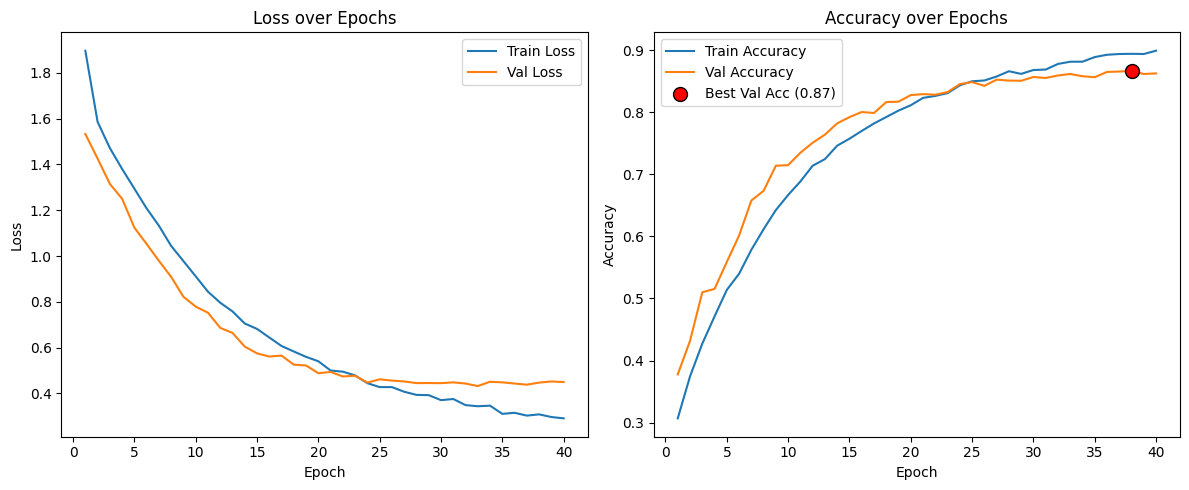

In [20]:
#display the training history 
IC.plot_metrics_history()

Predicting:   0%|          | 0/52 [00:00<?, ?it/s]

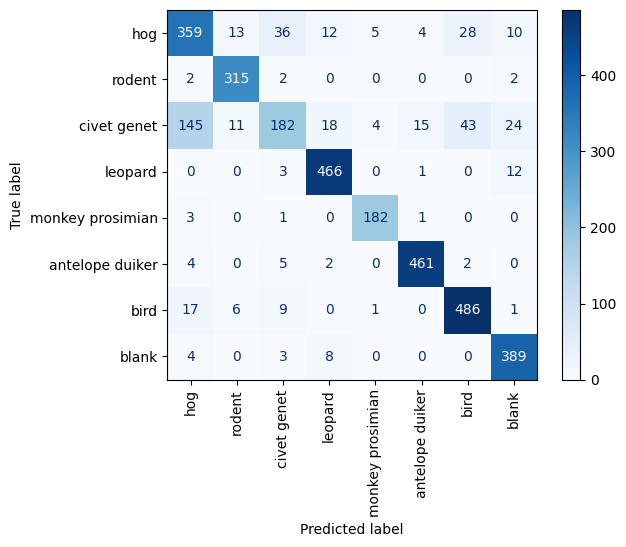

In [21]:
IC.Confusion_Matrix(val_loader)

The confusion matrix above summarizes the performance of the model on the validation dataset by comparing the predicted labels to the true labels. Each row represents the actual class, while each column represents the predicted class.

+ Diagonal values (from top-left to bottom-right) indicate the number of correct predictions for each class.

+ Off-diagonal values represent misclassifications — for example, the model misclassified 118 civet genet images as hog, which highlights a major confusion.

+ The "civet genet" class shows significant misclassification across multiple categories, indicating poor model performance on this class. This may be due to limited data or visual similarity to other animals, such as hogs or rodents.

+ In contrast, classes like leopard, bird, and blank show high accuracy, with most predictions correctly matching the true label.

This metric provides insight into class-level accuracy, helping identify which classes need better representation, more data, or additional preprocessing techniques like data augmentation.

## VI. Model Testing

Let's run predictions on a few test images.

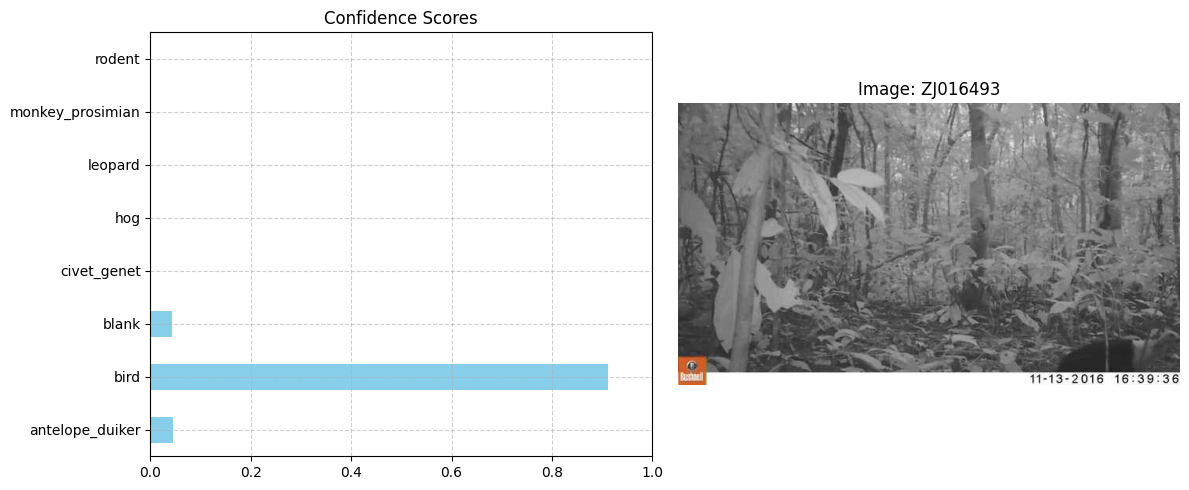

In [22]:
file_path="/kaggle/input/wildlife-conservation-in-cte-divoire/Wildlife_Conservation/test_features/ZJ016493.jpg"
image_id="ZJ016493"
IC.visualize_prediction(file_path, image_id)

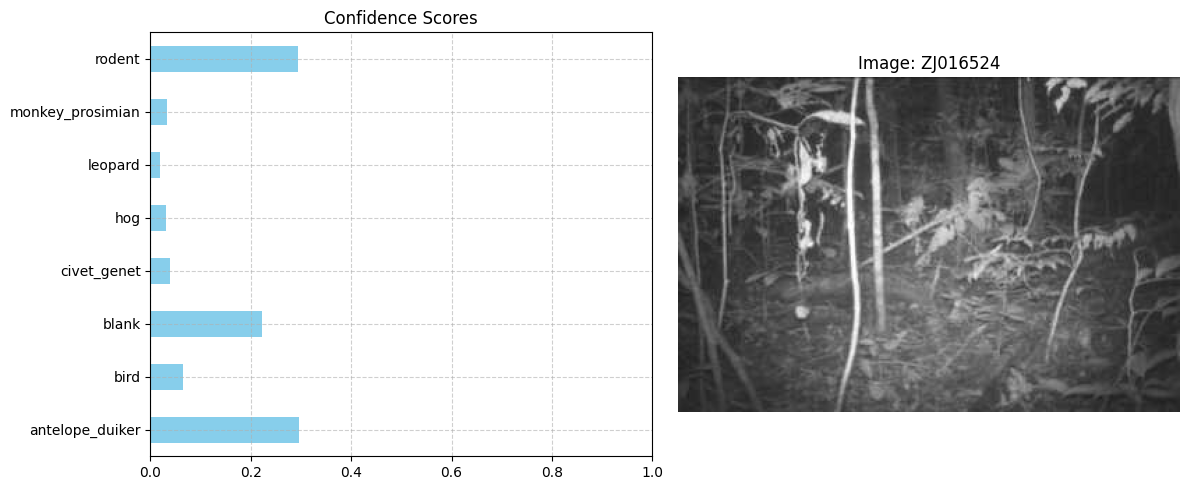

In [23]:
file_path="/kaggle/input/wildlife-conservation-in-cte-divoire/Wildlife_Conservation/test_features/ZJ016524.jpg"
image_id="ZJ016524"
IC.visualize_prediction(file_path, image_id)

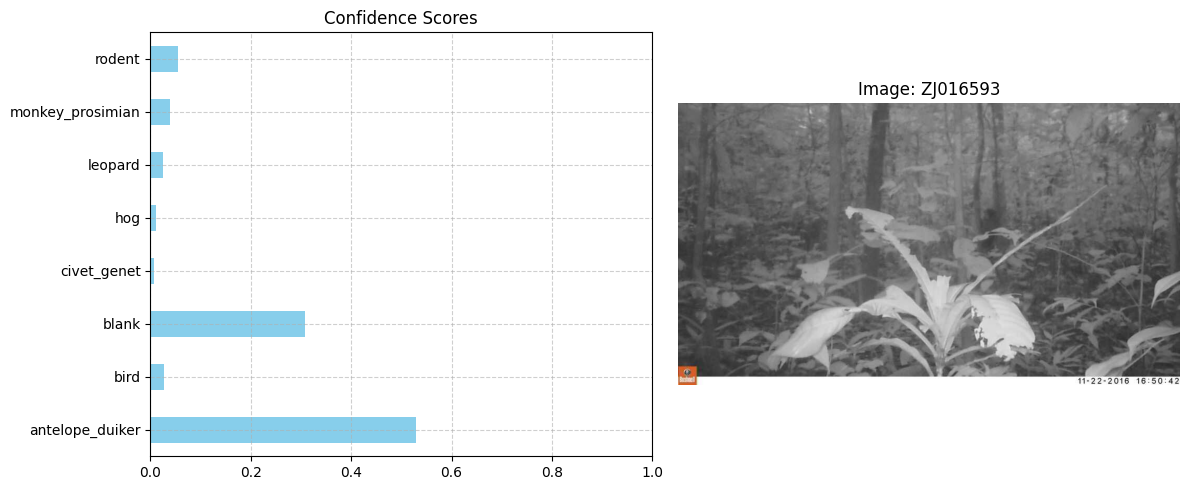

In [24]:
file_path="/kaggle/input/wildlife-conservation-in-cte-divoire/Wildlife_Conservation/test_features/ZJ016593.jpg"
image_id="ZJ016593"
IC.visualize_prediction(file_path, image_id)

## VII. Conclusion

In this notebook, I developed a modular ImageClassifier class to manage the key steps of an image classification pipeline, including training, validation, evaluation, and prediction. The class structure made the workflow clean, reusable, and easy to extend for different models and datasets. </br>

For the results, we can observe that the model achieved high accuracy on the validation dataset (over 87%), which is promising given the relatively low data quality. However, the class "civet genet" showed poor performance, maybe due to the common animal species or data quality. This issue could be addressed by collecting more representative data for that class or by applying data augmentation techniques to improve generalization.</br>

Overall, this project provided a solid foundation for experimenting with different architectures, loss functions, or optimizers. Future improvements could include adding support for data augmentation pipelines, fine-tuning pretrained models, or exploring more advanced evaluation metrics.